In [70]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.tseries.offsets import MonthEnd
warnings.filterwarnings('ignore')

In [71]:
data = pd.read_csv('tesla.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [72]:
df = pd.DataFrame()
df['Date'] = pd.to_datetime(data['Date'])
df['Values'] = data['Open']
df.set_index('Date', inplace=True)
df.head()

,Values
Date,
2010-06-29,19.000000
2010-06-30,25.790001
2010-07-01,25.000000
2010-07-02,23.000000
2010-07-06,20.000000


In [73]:
df.tail()

,Values
Date,
2017-03-13,244.820007
2017-03-14,246.110001
2017-03-15,257.000000
2017-03-16,262.399994
2017-03-17,264.000000


In [74]:
df.isna().sum()

,0
Values,0


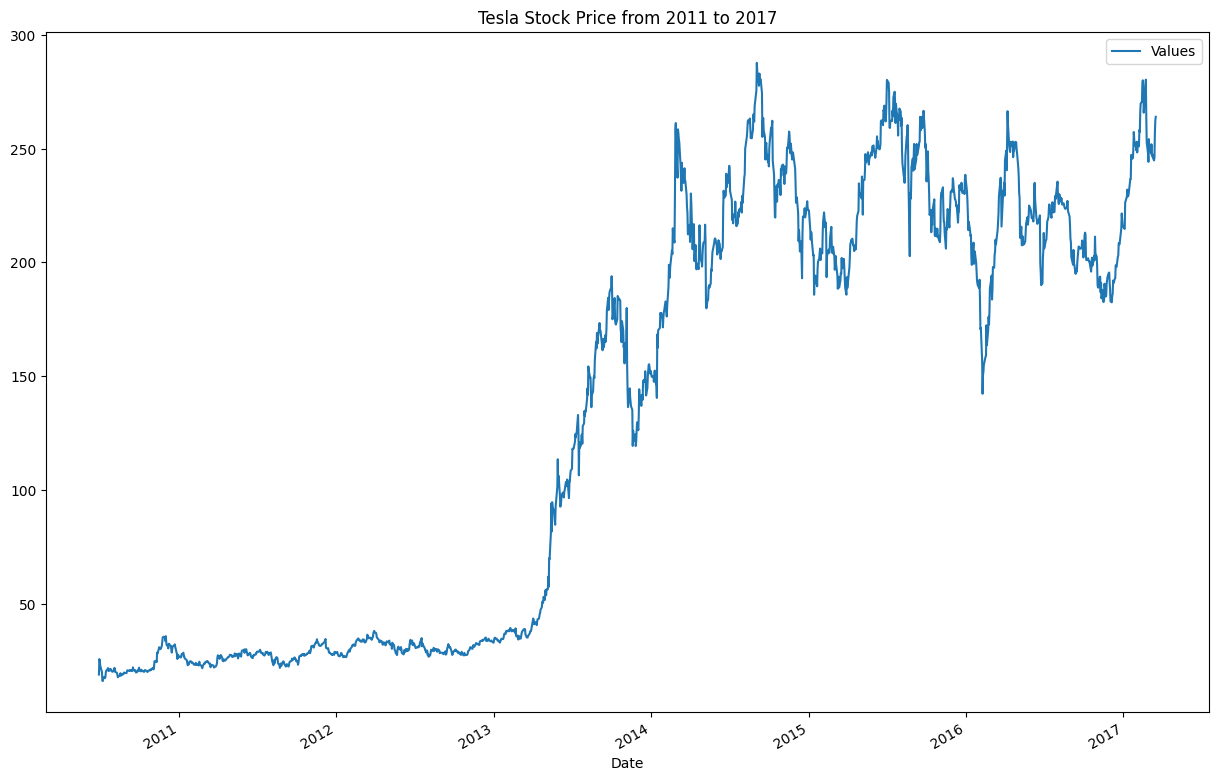

In [75]:
df.plot(figsize=(15, 10), kind='line')
plt.title("Tesla Stock Price from 2011 to 2017");
plt.show()

In [76]:
def dickeyFuller(df, target):

    # Dickey Fuller Test
    X = df.values
    result = adfuller(X)
    print("ADF Statistic test:", result[0])
    print('P - value: ', result[1])
    print('Number of lags used: ', result[2])
    print('Critical Values: ')
    for key, value in result[4].items():
        print('\t%s : %.3f' % (key, value))

    # Decompostion Seasonility if exists
    if result[0] > 0:
        df[target] = df[target].rolling(12).mean()

    return df

In [77]:
df = dickeyFuller(df, target='Value')

ADF Statistic test: -0.8181928810104885
P - value:  0.8137195490650421
Number of lags used:  1
Critical Values: 
	1% : -3.434
	5% : -2.863
	10% : -2.568


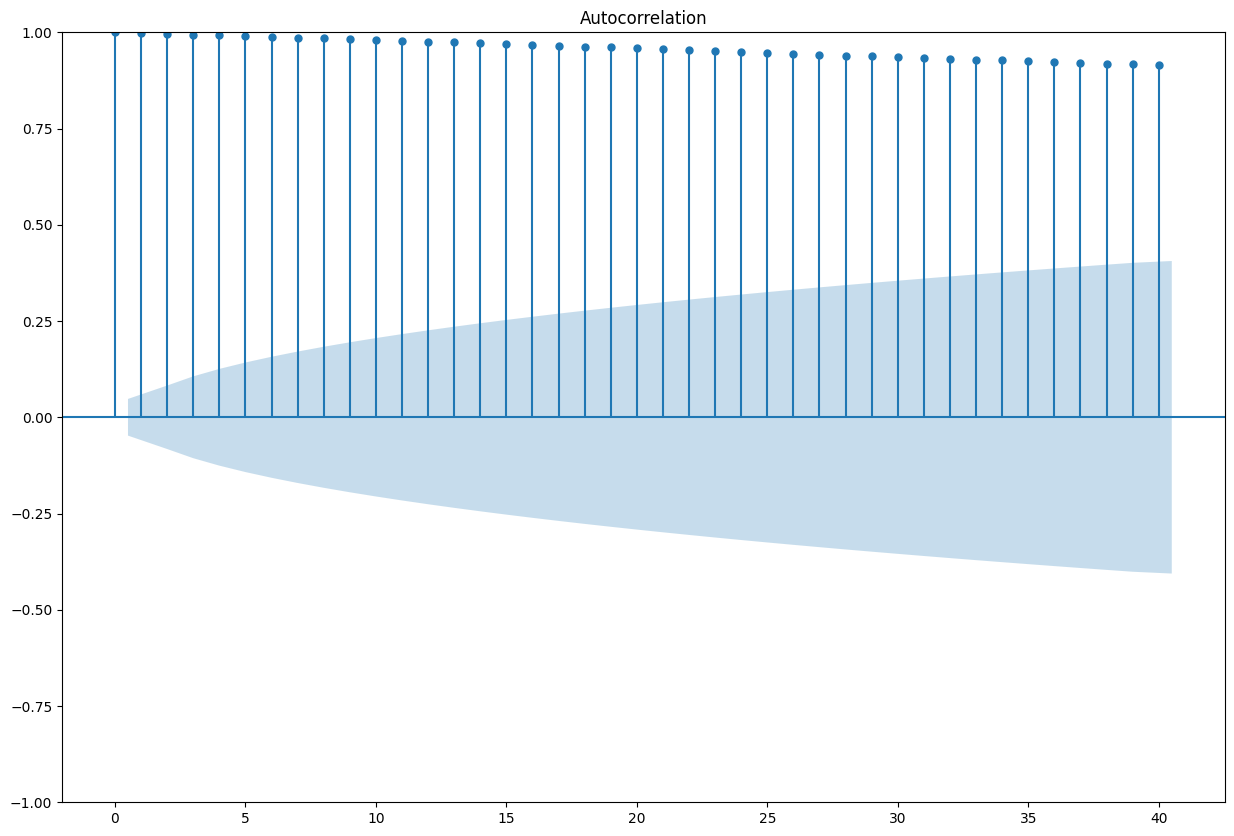

In [78]:
x = plot_acf(df, lags=40)
x.set_size_inches(15, 10, forward=True)
plt.show()

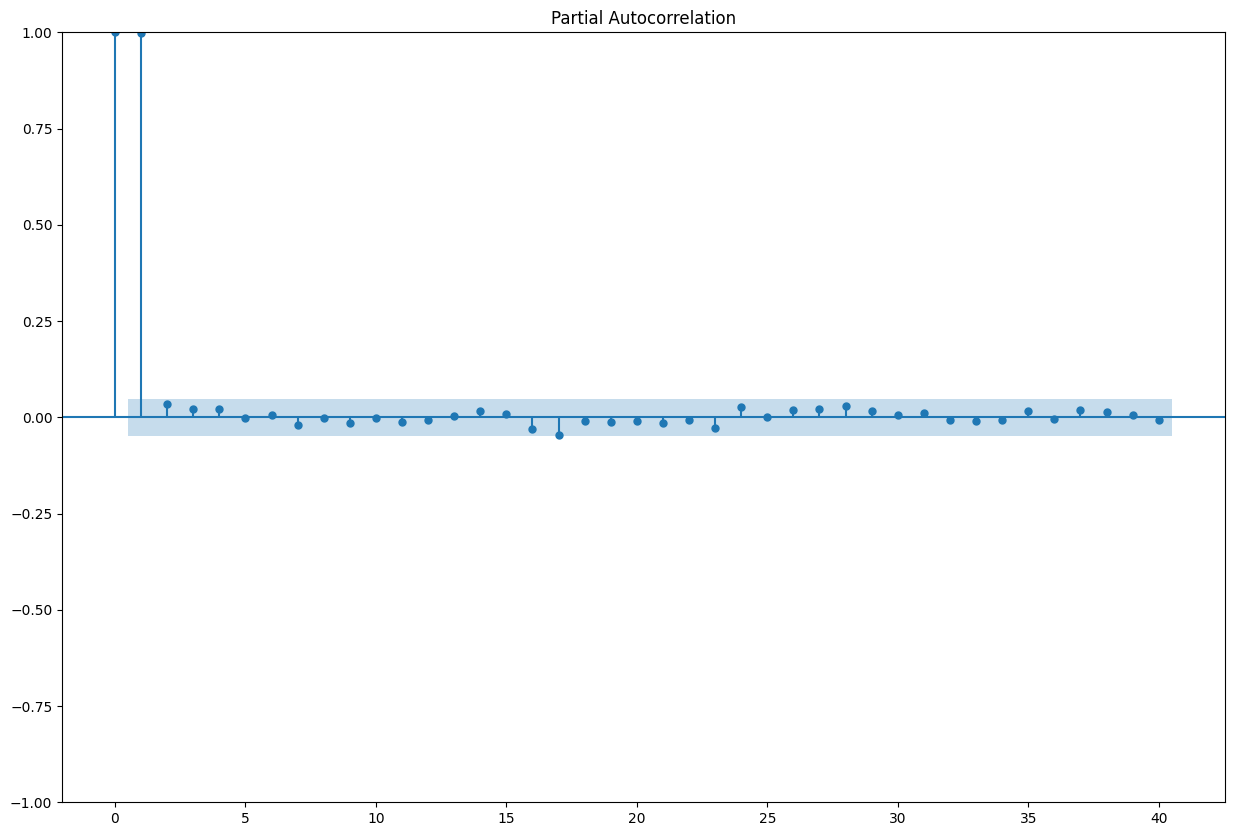

In [79]:
y = plot_pacf(df, lags=40)
y.set_size_inches(15, 10, forward=True)
plt.show()

In [80]:
size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [81]:
len(df_train)

1522

In [82]:
df_train.tail()

,Values
Date,
2016-07-08,217.800003
2016-07-11,219.960007
2016-07-12,224.100006
2016-07-13,225.500000
2016-07-14,223.119995


##ARIMA

In [100]:
date_range = pd.date_range(start='2015-01-01', periods=len(df), freq='M')
data.index = date_range  # Now df has a datetime index

# Extract the Series for modeling
series = df['Values']

# 3. Fit ARIMA model
model = ARIMA(series, order=(1, 1, 1))  # You can tune (p,d,q)
result = model.fit()

# 4. Define the forecast period
start = pd.Timestamp('2017-01-01')
end = pd.Timestamp('2017-08-01')

# 5. Compute how many months ahead to forecast
last_date = series.index[-1]
n_steps = 8


In [101]:
print(df.columns)
print(df.head())

Index(['Values'], dtype='object')
               Values
2015-01-31  19.000000
2015-02-28  25.790001
2015-03-31  25.000000
2015-04-30  23.000000
2015-05-31  20.000000


In [102]:
forecast = result.forecast(steps=n_steps)

# 8. Assign future datetime index
future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=n_steps, freq='M')
forecast.index = future_index

# 9. Show results
print(forecast)

2156-01-31    263.739307
2156-02-29    263.628129
2156-03-31    263.580715
2156-04-30    263.560494
2156-05-31    263.551871
2156-06-30    263.548193
2156-07-31    263.546624
2156-08-31    263.545956
Freq: ME, Name: predicted_mean, dtype: float64


In [103]:
print("Last date in series:", last_date)
print("Forecast start:", start)
print("Forecast end:", end)

Last date in series: 2155-12-31 00:00:00
Forecast start: 2017-01-01 00:00:00
Forecast end: 2017-08-01 00:00:00


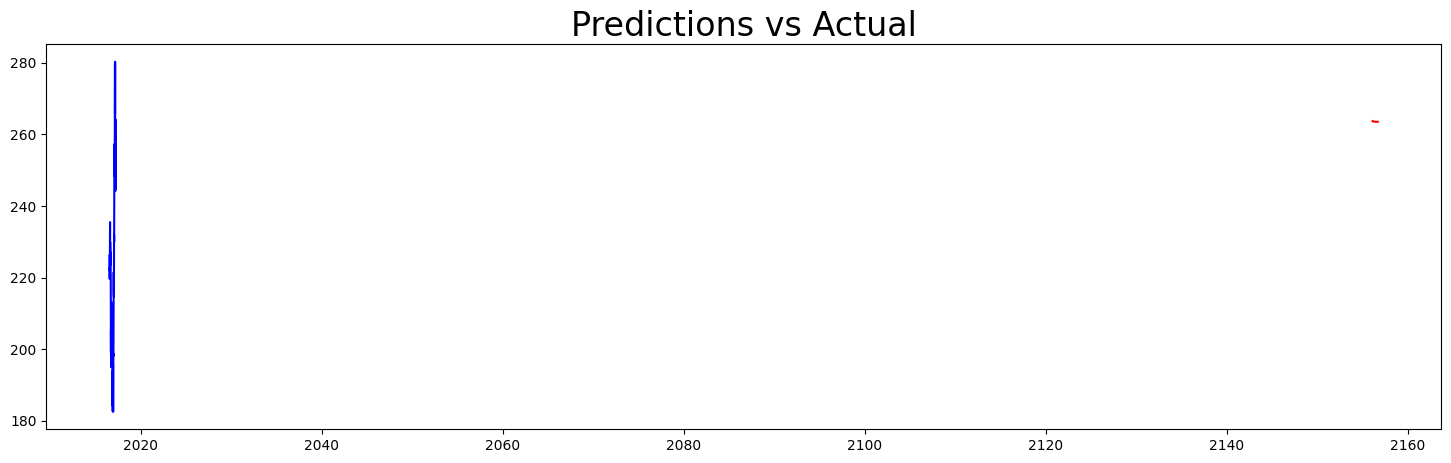

In [105]:
plt.figure(figsize=(18,5))
plt.plot(forecast, color = "red")
plt.plot(df_test, color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.plot(fontsize="x-large")

plt.show()

<Axes: xlabel='Date'>

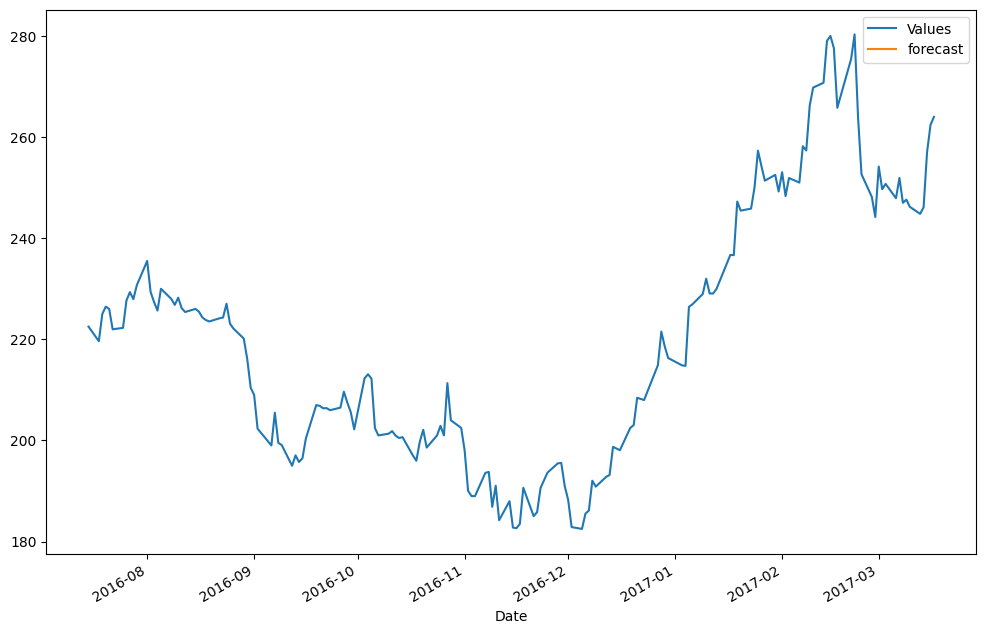

In [106]:
df_test['forecast'] = result.predict(start=size, end=len(df)-1, dynamic=True)
df_test[['Values','forecast']].plot(figsize=(12,8))

In [109]:
test = df_test['Values'][:len(forecast)]
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(test,forecast)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(test,forecast)))
print("Root Mean Squared Error {:.2f}".format(np.sqrt(mean_squared_error(test,forecast))))

Mean Absolute Error 39.64
Mean Squared Error 1578.10
Root Mean Squared Error 39.73


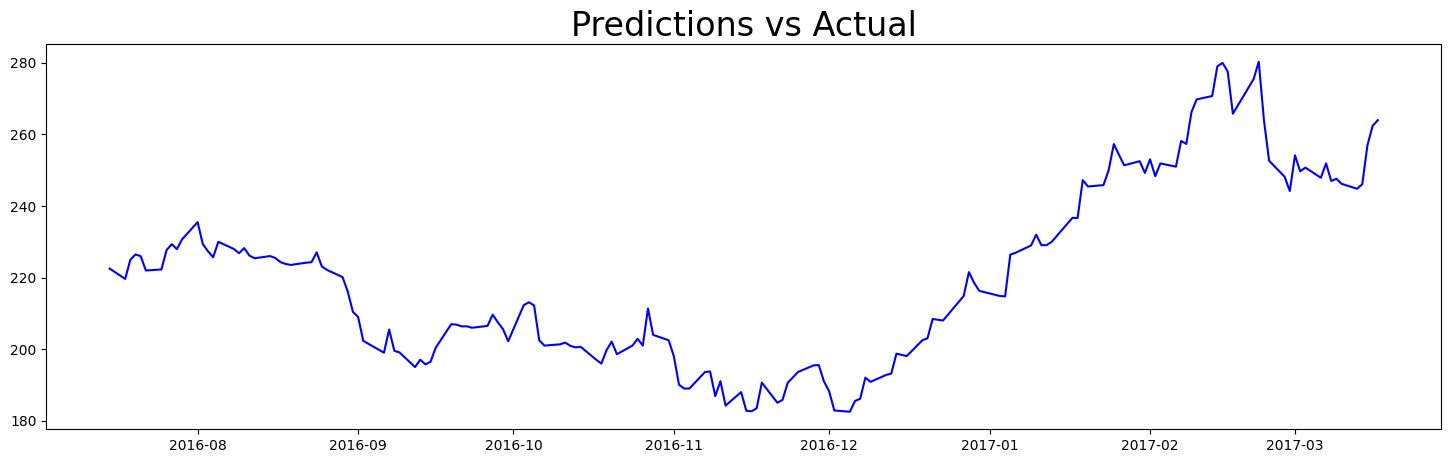

In [111]:
plt.figure(figsize=(18,5))
plt.plot(forecast[size:len(df)-1], color = "red")
plt.plot(df_test, color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.plot(fontsize="x-large")
plt.show()

<Axes: >

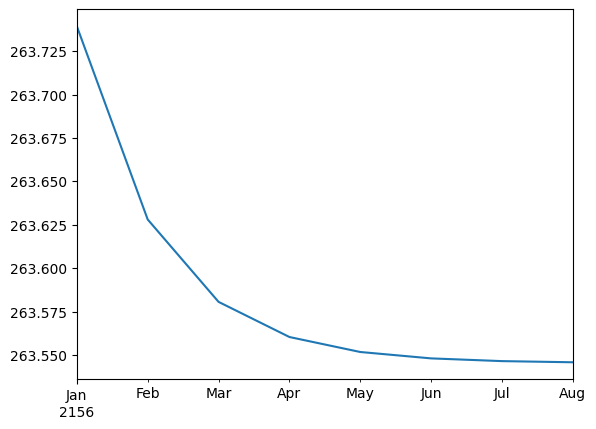

In [112]:
forecast.plot()